In [28]:
import SimFunctions
import SimRNG 
import SimClasses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

def sim(probArrH, probHighALC, probLowALC,MeanPTHX1,MeanPTLX1):  
    ZSimRNG = SimRNG.InitializeRNSeed()

    QueueH = SimClasses.FIFOQueue()
    QueueL = SimClasses.FIFOQueue()
    WaitH = SimClasses.DTStat()
    WaitL = SimClasses.DTStat()
    AbandonH = SimClasses.DTStat()
    AbandonL = SimClasses.DTStat()
    Server = SimClasses.Resource()
    Calendar = SimClasses.EventCalendar()

    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []

    TheDTStats.append(WaitH)
    TheDTStats.append(WaitL)
    TheDTStats.append(AbandonH)
    TheDTStats.append(AbandonL)
    TheQueues.append(QueueH)
    TheQueues.append(QueueL)
    TheResources.append(Server)

    numServer = 4
    Server.SetUnits(numServer)
    # Define the arrival rate and interarrival time
    arrRate = 15 # lambda
    probArrH = probArrH #qH
    probArrL = 1.0 - probArrH #qL
    MeanTBAH = 1.0/(arrRate*probArrH)
    MeanTBAL = 1.0/(arrRate*probArrL)

    # Define the mean service time for class H and L
    MeanSTH = 0.25
    MeanSTL = 0.25
    Phases = 1

    # Mean abandonment time for customers
    MeanPTHX1 = MeanPTHX1# Ahigh | Xhigh = 1
    MeanPTHX0 = MeanPTHX1 # Ahigh | Xhigh = 0
    MeanPTLX1 = MeanPTLX1# Alow | Xhigh = 1
    MeanPTLX0 = MeanPTLX1 # Alow | Xhigh = 0

    # ALC Risk
    probHighALC = probHighALC
    probLowALC = probLowALC

    # RunLength = 14400.0
    # WarmUp = 4320.0
    RunLength = 5500.0
    WarmUp = 500.0

    Cost = []
    gamma =1
    # Functions
    def ArrivalHigh(Customer):  
        if Customer.X == 1:
            SimFunctions.SchedulePlus(Calendar,"AbandonHigh",SimRNG.Expon(MeanPTHX1, 1),Customer)
        elif Customer.X == 0:
            SimFunctions.SchedulePlus(Calendar,"AbandonHigh",SimRNG.Expon(MeanPTHX0, 1),Customer)

        if Server.Busy < numServer:
            WaitH.Record(0)
            Server.Seize(1)
            SimFunctions.Schedule(Calendar,"EndOfServiceHigh",SimRNG.Erlang(Phases,MeanSTH,1))
        else:
            QueueH.Add(Customer) 

        # Schedule the next arrival with SchedulePlus
        NewCustomer = SimClasses.Entity()
        NewCustomer.ClassNum = 0
        NewCustomer.id = Customer.id + 1
        NewCustomer.setRealization(probHighALC)
        SimFunctions.SchedulePlus(Calendar,"ArrivalHigh",SimRNG.Expon(MeanTBAH, 1),NewCustomer)

    def ArrivalLow(Customer):
        if Customer.X == 1:
            SimFunctions.SchedulePlus(Calendar,"AbandonLow",SimRNG.Expon(MeanPTLX1, 1),Customer)
        elif Customer.X == 0:
            SimFunctions.SchedulePlus(Calendar,"AbandonLow",SimRNG.Expon(MeanPTLX0, 1),Customer)

        if Server.Busy < numServer:
            WaitL.Record(0)
            Server.Seize(1)
            SimFunctions.Schedule(Calendar,"EndOfServiceLow",SimRNG.Erlang(Phases,MeanSTL,1))
        else:
            QueueL.Add(Customer) 

        # Schedule the next arrival with SchedulePlus
        NewCustomer = SimClasses.Entity()
        NewCustomer.ClassNum = 1
        NewCustomer.id = Customer.id + 1
        NewCustomer.setRealization(probLowALC)
        SimFunctions.SchedulePlus(Calendar,"ArrivalLow",SimRNG.Expon(MeanTBAL, 1),NewCustomer)

    def AbandonHigh(Customer):
        # When it's time for abandonment,
        # Check if the customer is still in queue, if yes, remove from queue
        if QueueH.isInQueue(Customer):
            if Customer.X == 1:
                AbandonH.Record(1)
            else:
                AbandonH.Record(0)
            QueueH.RemoveCustomer(Customer)

    def AbandonLow(Customer):
        # When it's time for abandonment,
        # Check if the customer is still in queue, if yes, remove from queue
        if QueueL.isInQueue(Customer):
            if Customer.X == 1:
                AbandonL.Record(1)
            else:
                AbandonL.Record(0)
            QueueL.RemoveCustomer(Customer)

    def EndOfServiceHigh():
        AbandonH.Record(0)
        if QueueH.NumQueue() > 0:
            DepartingCustomer = QueueH.Remove()
            WaitH.Record(SimClasses.Clock - DepartingCustomer.CreateTime)
            SimFunctions.Schedule(Calendar,"EndOfServiceHigh",SimRNG.Erlang(Phases,MeanSTH,1))
        elif QueueL.NumQueue() > 0:
            DepartingCustomer = QueueL.Remove()
            WaitL.Record(SimClasses.Clock - DepartingCustomer.CreateTime)
            SimFunctions.Schedule(Calendar,"EndOfServiceLow",SimRNG.Erlang(Phases,MeanSTL,1))
        else:
            Server.Free(1)

    def EndOfServiceLow():
        AbandonL.Record(0)
        if QueueH.NumQueue() > 0:
            DepartingCustomer = QueueH.Remove()
            WaitH.Record(SimClasses.Clock - DepartingCustomer.CreateTime)
            SimFunctions.Schedule(Calendar,"EndOfServiceHigh",SimRNG.Erlang(Phases,MeanSTH,1))
        elif QueueL.NumQueue() > 0:
            DepartingCustomer = QueueL.Remove()
            WaitL.Record(SimClasses.Clock - DepartingCustomer.CreateTime)
            SimFunctions.Schedule(Calendar,"EndOfServiceLow",SimRNG.Erlang(Phases,MeanSTL,1))
        else:
            Server.Free(1)

    def CI_95(data):
        a = np.array(data, dtype=object)
        n = len(a)
        m = np.mean(a)
        sd = np.std(a,ddof=1)
        hw = 1.96*sd / np.sqrt(n)
#         return m, hw, m-hw,m+hw
#         return m, hw, [m-hw,m+hw]
        return m-hw, m+hw
    
    for reps in range(0,30,1):
        # Initialize the system
        SimFunctions.SimFunctionsInit(Calendar,TheQueues,TheCTStats,TheDTStats,TheResources)

        # Schedule arrival for high ALC
        FirstCustomer = SimClasses.Entity()
        FirstCustomer.ClassNum = 0
        FirstCustomer.setRealization(probHighALC)
        SimFunctions.SchedulePlus(Calendar,"ArrivalHigh",SimRNG.Expon(MeanTBAH, 1),FirstCustomer)

        # Schedule arrival for Low ALC
        SecCustomer = SimClasses.Entity()
        SecCustomer.ClassNum = 1
        SecCustomer.setRealization(probLowALC)
        SimFunctions.SchedulePlus(Calendar,"ArrivalLow",SimRNG.Expon(MeanTBAL, 1),SecCustomer)
        SimFunctions.Schedule(Calendar,"EndSimulation",RunLength)
        SimFunctions.Schedule(Calendar,"ClearIt",WarmUp)

        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "ArrivalHigh":
            ArrivalHigh(NextEvent.WhichObject)
        elif NextEvent.EventType == "ArrivalLow":
            ArrivalLow(NextEvent.WhichObject)

        while NextEvent.EventType != "EndSimulation":
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            if NextEvent.EventType == "ArrivalHigh":
                ArrivalHigh(NextEvent.WhichObject)
            elif NextEvent.EventType == "ArrivalLow":
                ArrivalLow(NextEvent.WhichObject)
            elif NextEvent.EventType == "AbandonHigh":
                AbandonHigh(NextEvent.WhichObject)
            elif NextEvent.EventType == "AbandonLow":
                AbandonLow(NextEvent.WhichObject)
            elif NextEvent.EventType == "EndOfServiceHigh":
                EndOfServiceHigh() 
            elif NextEvent.EventType == "EndOfServiceLow":
                EndOfServiceLow() 
            elif NextEvent.EventType == "ClearIt":
                SimFunctions.ClearStats(TheCTStats,TheDTStats)
#         AllAbandonH.append(AbandonH.Mean())
#         AllAbandonL.append(AbandonL.Mean())
        Cost.append(gamma*(AbandonH.Sum+AbandonL.Sum)/(AbandonH.NumberOfObservations+AbandonL.NumberOfObservations))
#     return np.mean(AllAbandonH), np.mean(AllAbandonL), np.mean(Cost), CI_95(Cost)
    return Cost

In [41]:
# Fixed risk, compare LOS
theta1 = [0.1,0.2,0.3,0.4,0.4,0.5,0.6]
theta2 = [0.4,0.4,0.3,0.2,0.1,0.1,0.1]
x43 = []
y43 = []
lb43 = []
ub43 = []
for i in range (0,len(theta1),1):
    CostList1 = sim(0.3,0.4,0.3,theta1[i],theta2[i])
    CostList2 = sim(0.7,0.3,0.4,theta2[i],theta1[i])
    data = np.array(CostList1) - np.array(CostList2)
    mean = np.mean(data)
    (lb1, ub1) = st.norm.interval(alpha=0.95, loc=mean, scale=st.sem(data))
    x43.append(theta1[i]/theta2[i])
    y43.append(mean)
    lb43.append(lb1)
    ub43.append(ub1) 

theta1[i]:  0.1  theta2[i]:  0.4
theta1[i]:  0.2  theta2[i]:  0.4
theta1[i]:  0.3  theta2[i]:  0.3
theta1[i]:  0.4  theta2[i]:  0.2
theta1[i]:  0.4  theta2[i]:  0.1
theta1[i]:  0.5  theta2[i]:  0.1
theta1[i]:  0.6  theta2[i]:  0.1


In [34]:
# Fixed risk, compare LOS
theta1 = [0.1,0.2,0.3,0.4,0.4,0.5,0.6]
theta2 = [0.4,0.4,0.3,0.2,0.1,0.1,0.1]
x64 = []
y64 = []
lb64 = []
ub64 = []
for i in range (0,len(theta1),1):
    CostList1 = sim(0.3,0.6,0.4,theta1[i],theta2[i])
    CostList2 = sim(0.7,0.4,0.6,theta2[i],theta1[i])
    data = np.array(CostList1) - np.array(CostList2)
    mean = np.mean(data)
    (lb1, ub1) = st.norm.interval(alpha=0.95, loc=mean, scale=st.sem(data))
    x64.append(theta1[i]/theta2[i])
    y64.append(mean)
    lb64.append(lb1)
    ub64.append(ub1) 

theta1[i]:  0.1  theta2[i]:  0.4
theta1[i]:  0.2  theta2[i]:  0.4
theta1[i]:  0.3  theta2[i]:  0.3
theta1[i]:  0.4  theta2[i]:  0.2
theta1[i]:  0.4  theta2[i]:  0.1
theta1[i]:  0.5  theta2[i]:  0.1
theta1[i]:  0.6  theta2[i]:  0.1


In [35]:
# Fixed risk, compare LOS
theta1 = [0.1,0.2,0.3,0.4,0.4,0.5,0.6]
theta2 = [0.4,0.4,0.3,0.2,0.1,0.1,0.1]
x73 = []
y73 = []
lb73 = []
ub73 = []
for i in range (0,len(theta1),1):
    CostList1 = sim(0.3,0.7,0.3,theta1[i],theta2[i])
    CostList2 = sim(0.7,0.3,0.7,theta2[i],theta1[i])
    data = np.array(CostList1) - np.array(CostList2)
    mean = np.mean(data)
    (lb1, ub1) = st.norm.interval(alpha=0.95, loc=mean, scale=st.sem(data))
    x73.append(theta1[i]/theta2[i])
    y73.append(mean)
    lb73.append(lb1)
    ub73.append(ub1) 

theta1[i]:  0.1  theta2[i]:  0.4
theta1[i]:  0.2  theta2[i]:  0.4
theta1[i]:  0.3  theta2[i]:  0.3
theta1[i]:  0.4  theta2[i]:  0.2
theta1[i]:  0.4  theta2[i]:  0.1
theta1[i]:  0.5  theta2[i]:  0.1
theta1[i]:  0.6  theta2[i]:  0.1


In [36]:
# Fixed risk, compare LOS
theta1 = [0.1,0.2,0.3,0.4,0.4,0.5,0.6]
theta2 = [0.4,0.4,0.3,0.2,0.1,0.1,0.1]
x82 = []
y82 = []
lb82 = []
ub82 = []
for i in range (0,len(theta1),1):
    CostList1 = sim(0.3,0.8,0.2,theta1[i],theta2[i])
    CostList2 = sim(0.7,0.2,0.8,theta2[i],theta1[i])
    data = np.array(CostList1) - np.array(CostList2)
    mean = np.mean(data)
    (lb1, ub1) = st.norm.interval(alpha=0.95, loc=mean, scale=st.sem(data))
    x82.append(theta1[i]/theta2[i])
    y82.append(mean)
    lb82.append(lb1)
    ub82.append(ub1) 

theta1[i]:  0.1  theta2[i]:  0.4
theta1[i]:  0.2  theta2[i]:  0.4
theta1[i]:  0.3  theta2[i]:  0.3
theta1[i]:  0.4  theta2[i]:  0.2
theta1[i]:  0.4  theta2[i]:  0.1
theta1[i]:  0.5  theta2[i]:  0.1
theta1[i]:  0.6  theta2[i]:  0.1


In [42]:
# Fixed risk, compare LOS
theta1 = [0.1,0.2,0.3,0.4,0.4,0.5,0.6]
theta2 = [0.4,0.4,0.3,0.2,0.1,0.1,0.1]
x91 = []
y91 = []
lb91 = []
ub91 = []
for i in range (0,len(theta1),1):
    CostList1 = sim(0.3,0.9,0.1,theta1[i],theta2[i])
    CostList2 = sim(0.7,0.1,0.9,theta2[i],theta1[i])
    data = np.array(CostList1) - np.array(CostList2)
    mean = np.mean(data)
    (lb1, ub1) = st.norm.interval(alpha=0.95, loc=mean, scale=st.sem(data))
    x91.append(theta1[i]/theta2[i])
    y91.append(mean)
    lb91.append(lb1)
    ub91.append(ub1) 

theta1[i]:  0.1  theta2[i]:  0.4
theta1[i]:  0.2  theta2[i]:  0.4
theta1[i]:  0.3  theta2[i]:  0.3
theta1[i]:  0.4  theta2[i]:  0.2
theta1[i]:  0.4  theta2[i]:  0.1
theta1[i]:  0.5  theta2[i]:  0.1
theta1[i]:  0.6  theta2[i]:  0.1


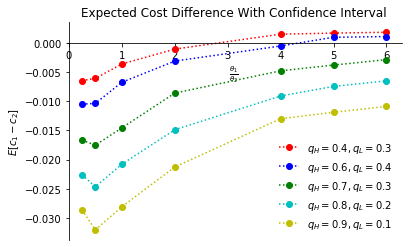

In [47]:
fig, ax = plt.subplots()
ax.plot(x43,y43,'o:r', label = r'$q_H = 0.4, q_L = 0.3$')
ax.plot(x64,y64,'o:b', label = r'$q_H = 0.6, q_L = 0.4$')
ax.plot(x73,y73,'o:g', label = r'$q_H = 0.7, q_L = 0.3$')
ax.plot(x82,y82,'o:c', label = r'$q_H = 0.8, q_L = 0.2$')
ax.plot(x91,y91,'o:y', label = r'$q_H = 0.9, q_L = 0.1$')

#ax.plot(x,[0]*len(theta1))
#ax.fill_between(x, lb, ub, color='b', alpha=.1)
ax.set_title('Expected Cost Difference With Confidence Interval')
ax.set_xlabel(r'$\frac{\theta_1}{\theta_2}$')
ax.set_ylabel(r'$E[c_1-c_2]$')

# set the x-spine (see below for more info on `set_position`)
ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position('zero')

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()
ax.legend(loc='lower right', frameon=False)